In [5]:
import numpy as np
import pyvista as pv

from scipy.spatial import Voronoi, ConvexHull

import pyvoro

from threading import Thread

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from matplotlib.animation import FuncAnimation



In [2]:
# points = np.load('early_poss.npy')


# ps = np.load('ps_early.npy')



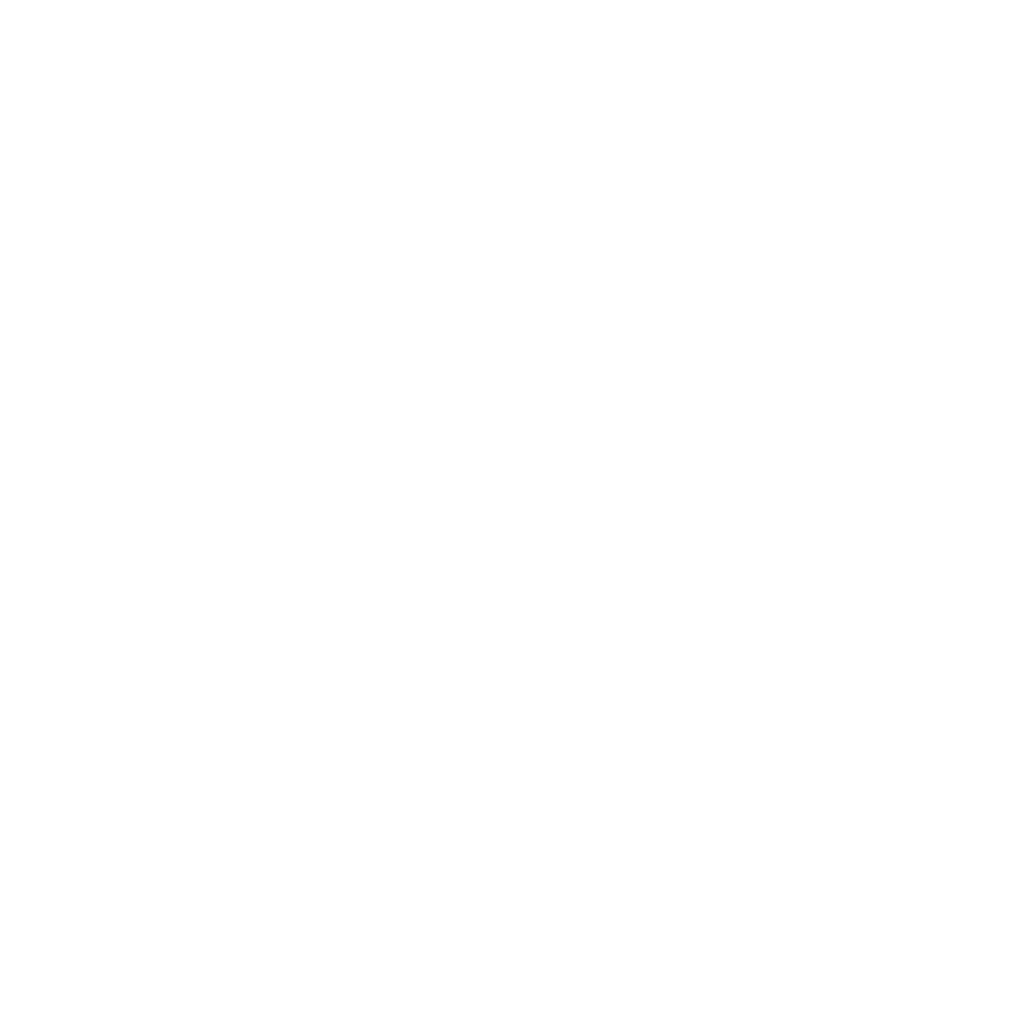

In [11]:

rng = np.random.default_rng(11)

fig = plt.figure(figsize=(10,10), constrained_layout=True)
ax = fig.add_subplot(111, projection='3d')



def get_voronoi(points, ps):

    extra = np.concatenate([points, points + 1.*ps, ])

    voronoi = pyvoro.compute_voronoi(
    extra, # point positions
    [[-100., 100.0], [-100.0, 100.0], [-100.0, 100.0]], # limits
    2.0, # block size

    )
    return voronoi


def get_face(vnoicell, p):
    faces = []
    # the vertices are the corner points of the Voronoi cell
    vertices = np.array(vnoicell['vertices'])
    # cycle through all faces of the polygon
    for face in vnoicell['faces']:
        faces.append(vertices[np.array(face['vertices'])])
    

    dots = []
    for face in faces:
        # check the normal of the face
        normal = np.cross(face[1] - face[0], face[2] - face[0])
        normal = normal / np.linalg.norm(normal)
        
        dot = np.dot(normal, p)

        dots.append(dot)

    best = np.argmin(dots)
    face = faces[best]

    return face


def make_plot(points, ps, ax, properties, i):
    global voronois

    all_three = True

    originals = []
    
    voronoi = np.array(list(voronois[i][:5000]))
    sorted = np.argsort(points[:, 1])

    print(len(voronoi))
    # for each Voronoi cell, plot all the faces of the corresponding polygon
    for vnoicell, p, prop in zip(voronoi[sorted], ps[sorted], properties[sorted]):

        face = get_face(vnoicell, p)
       
        originals.append(face)

    colors = np.array([[1., 1., 1.]]*len(originals))
    colors[properties == 3] *= 0.7
    colors[properties == 1] *= 0.8

    collection = Poly3DCollection(list(originals), alpha=1., 
                            facecolors=colors,
                            linewidths=0.2,edgecolors='black')
    
    ax.add_collection3d(collection)


    if not all_three:
        return

    rot1 = [np.vstack([o[:,0], o[:,2], o[:,1]]).T for o in originals]
    offset1 = np.array([0,0,50])
    rot2 = [np.vstack([o[:,0], -o[:,2], o[:,1]]).T for o in originals]
    offset2 = np.array([0,0,-50])

    polygon = Poly3DCollection([rot1 + offset1], alpha=1.,
                            facecolors=colors,
                            linewidths=0.2,edgecolors='black')
    ax.add_collection3d(polygon)
    
    polygon = Poly3DCollection([rot2+ offset2], alpha=1.,
                        facecolors=colors,
                        linewidths=0.2,edgecolors='black')
    ax.add_collection3d(polygon)
        


# make_plot(points, ps, ax)

ax.set_xlim(-45,45)
ax.set_ylim(-45,45)
ax.set_zlim(-45,45)


# remove the axes
ax._axis3don = False

# set the viewing angle
ax.view_init(elev=0, azim=-90)


all_points = np.load('toshow.npy')
all_ps = np.load('toshow_p.npy')
properties = np.load('toshow_props.npy')



# make animation

def update(i):
    print(i)
    ax.clear()
    points = all_points[i] 
    ps = all_ps[i]


    make_plot(points, ps, ax, properties[0], i)
        

    ax.set_xlim(-45,45)
    ax.set_ylim(-45,45)
    ax.set_zlim(-45,45)


    # remove the axes
    ax._axis3don = False

    # set the viewing angle
    ax.view_init(elev=0, azim=-90)

    return ax


def add_voronoi(points, ps, i):
    global voronois

    voronoi = get_voronoi(points, ps)
    voronois[i] = voronoi
    print(i, "done")


redo = False


if redo:
    voronois = [[] for i in range(len(all_points))]
    threads = []


    for i in range(len(all_points)):
        points = all_points[i]
        ps = all_ps[i]
        thread = Thread(target=add_voronoi, args=(points, ps, i))
        thread.start()
        threads.append(thread)

    for thread in threads:
        thread.join()

    np.save('toshow_voronois.npy', voronois, allow_pickle=True)
# else:
    # voronois = np.load('toshow_voronois.npy', allow_pickle=True)

# ani = FuncAnimation(fig, update, frames=range(len(all_points)), repeat=False, interval = 1)

# ani.save('toshow.mp4', writer='ffmpeg', fps=1,)


In [20]:

all_faces = []

for i in range(len(all_points)):
    print(i/len(all_points), end='\r')
    points = all_points[i]
    ps = all_ps[i]
    properties = all_ps[i]

    faces = []

    voronoi = np.array(list(voronois[i][:5000]))
    sorted = np.argsort(points[:, 1])

    # for each Voronoi cell, plot all the faces of the corresponding polygon
    for vnoicell, p, prop in zip(voronoi[sorted], ps[sorted], properties[sorted]):
        face = get_face(vnoicell, p)
        faces.append(face)

    all_faces.append(faces)

all_faces = np.array(all_faces, dtype = object)

np.save('toshow_faces.npy', all_faces, allow_pickle=True)

NameError: name 'voronois' is not defined

0
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
0


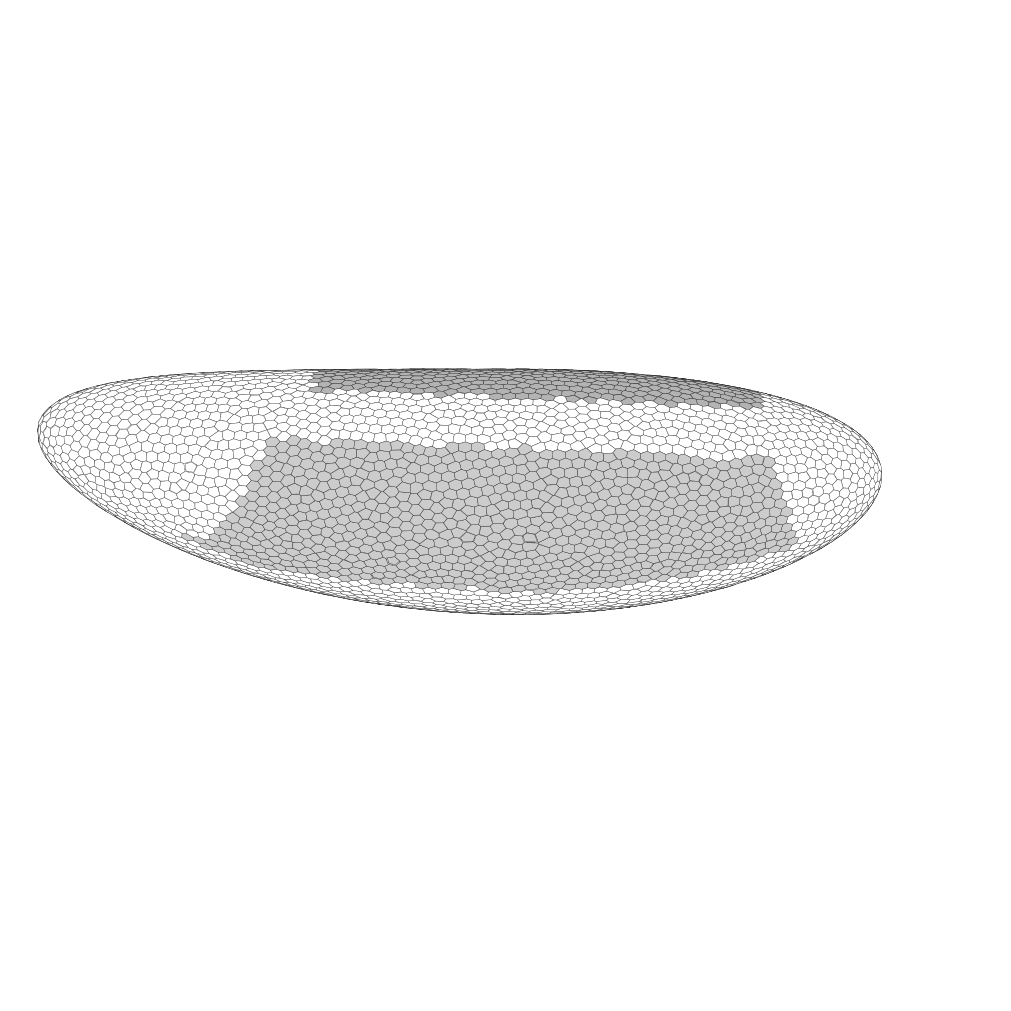

In [29]:
from functools import partial

all_faces = np.load('toshow_faces.npy', allow_pickle=True)


all_points = np.load('toshow.npy')
properties = np.load('toshow_props.npy')


def make_plot_from_faces(faces, ax, props):

    colors = np.array([[1., 1., 1.]]*len(faces))
    colors[props == 3] *= 0.7
    colors[props == 1] *= 0.8

    collection = Poly3DCollection(list(faces), alpha=1., 
                            facecolors=colors,
                            linewidths=0.2,edgecolors='black',)
        
    ax.add_collection3d(collection)


def update_from_faces(i):
    print(i)
    ax.clear()
    faces = all_faces[i] 

    positions  = all_points[i]
    sorted = np.argsort(positions[:, 1])
    props = properties[0][sorted]


    make_plot_from_faces(faces, ax, props)
        

    ax.set_xlim(-45,45)
    ax.set_ylim(-45,45)
    ax.set_zlim(-45,45)


    # remove the axes
    ax._axis3don = False

    # set the viewing angle
    ax.view_init(elev=0, azim=-90)

    return ax


fig = plt.figure(figsize=(10,10), constrained_layout=True)

ax = fig.add_subplot(111, projection='3d')

#add light source
# ax.view_init(elev=0, azim=-90)




ani = FuncAnimation(fig, update_from_faces, frames=range(len(all_faces)), repeat=False, interval = 1)

ani.save('toshow_t2.mp4', writer='ffmpeg', fps=1,)


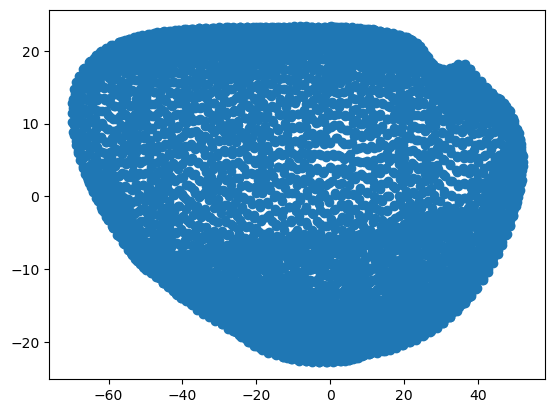

In [4]:
plt.scatter(all_points[7][:,0],all_points[7][:,2],)

# mercador projection

from wikipedia:

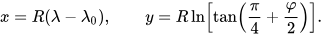

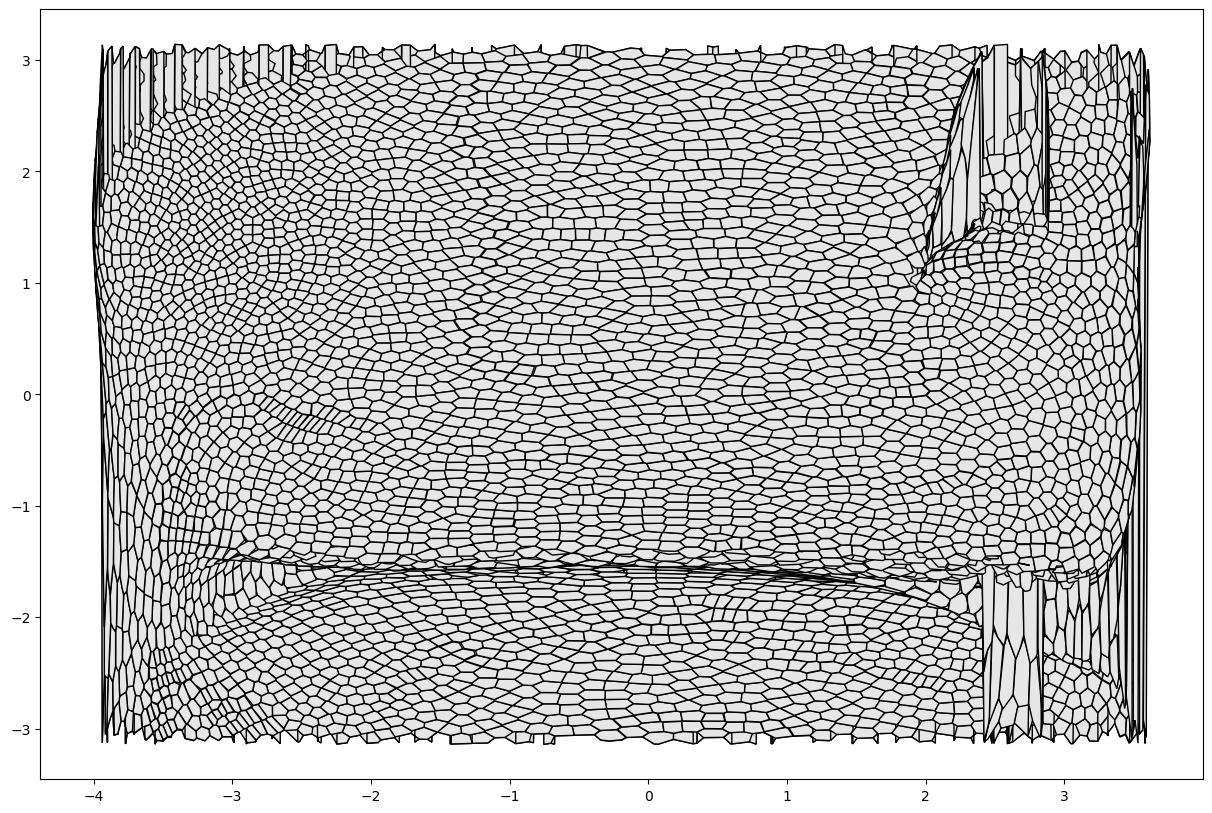

In [5]:
def mercator(long, lat):
    x = long
    y = np.log(np.tan(lat) + 1.0/np.cos(lat))
    return x, y


plt.figure(figsize=(15,10))

minmaxx = (-70, 70) 
for face in originals:
    longd = np.arctan2(face[:,2], face[:,1])
    latd = np.arcsin(face[:,0]/(np.linalg.norm(face, axis=1) + 10.))

    x, y = mercator(longd, latd)

    # draw the face as a polygon
    # c = (face[0,0]-minmaxx[0])/(2.*minmaxx[1])
    c = 0.9
    plt.fill(y*3, x, color=(c,c,c), alpha=1, edgecolor='black')

plt.show()

In [46]:
points = np.load('early_poss.npy')

tri = Voronoi(points)

# get neighbors
indptr, indices = tri.vertex_neighbor_vertices

nbs = []
# get neighbors for each point
for i in range(len(points)):
    nbs.append(indices[indptr[i]:indptr[i+1]])


new_points = []

seen_points = []

original_index = []

for i in range(len(points)):
    print(i/len(points), end='\r')
    new_points.append(points[i])
    random_color = np.random.rand(3)
    original_index.append(i) 
    for j in nbs[i]:
        if set([i, j]) in seen_points:
            continue
        new_points.append((points[i] + points[j]) / 2)
        seen_points.append(set([i, j]))
        original_index.append(i)

new_points = np.array(new_points)


In [15]:
# new_points


array([[ 22.953701  ,   0.24650294, -16.557964  ],
       [ 21.586704  ,  -0.11349684,   2.6884604 ],
       [ 21.893291  ,   1.7138588 ,   2.5508213 ],
       ...,
       [ -5.0137353 ,  22.032719  ,  -7.3438745 ],
       [ -6.032687  , -13.591119  ,  18.944372  ],
       [-32.05221   ,  20.289392  ,  -1.8309369 ]], dtype=float32)

In [27]:
newdel = Delaunay(new_points)

simplex = newdel.find_simplex(new_points[1])

In [23]:
indptr, indices = newdel.vertex_neighbor_vertices


pd_style = []

for k in range(new_points.shape[0]):
    nbs = indices[indptr[k]:indptr[k+1]]
    pd_style.append(len(nbs))
    for nb in nbs:
        new_points(nb)

38658

In [82]:
points = np.load('early_poss.npy')

cloud = pv.PolyData(points)
surf = cloud.delaunay_3d(alpha = 9999.)



# show the points
pl = pv.Plotter()
cloud2 = pv.PolyData(new_points)

pl.add_mesh(cloud2, point_size=5, color='green')
pl.add_mesh(cloud, point_size=5, color='red')
pl.add_mesh(surf,  show_edges=True,)
pl.show()


Widget(value='<iframe src="http://localhost:51087/index.html?ui=P_0x1f8eb201580_11&reconnect=auto" class="pyvi…

In [38]:
cloud = pv.PolyData(new_points)
surf = cloud.delaunay_3d(alpha = 9999.)


In [44]:
from numba import njit


@njit(parallel=True)
def do_da_thing(offsets, cells, surf_points,  points):
    currenti = 0

    scalar = []

    good_cells = []
    n_good = 0
    for offset in offsets:
        # print(currenti/len(offsets), n_good, end='\r')

        n_tri = cells[offset]
        tri = cells[(offset+1):(offset+n_tri+1)]

        has_broken = False
        for point in tri:
            sp = surf_points[point]
            for p in points:
                if np.allclose(sp, p):
                    scalar.append(p)
                    has_broken = True
                    break
            if has_broken:
                break

        if has_broken:
            good_cells.append(n_tri)
            for t in tri:
                good_cells.append(t)
            n_good += 1

        currenti += 1

good_cells = do_da_thing(surf.offset, surf.cells, surf.points, new_points)

c:\Users\jakob\miniconda3\envs\reworked\lib\site-packages\numba\core\typed_passes.py:336: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see https://numba.readthedocs.io/en/stable/user/parallel.html#diagnostics for help.

File "..\..\..\..\..\AppData\Local\Temp\ipykernel_140\2462652661.py", line 4:
<source missing, REPL/exec in use?>

  warnings.warn(errors.NumbaPerformanceWarning(msg,

KeyboardInterrupt



In [69]:
surf.cells = np.array(good_cells)

array([   3,   35,   25, 2373,    3], dtype=int64)

In [62]:
points[closest]


array([ 25.296047 ,  17.125185 , -10.3861265], dtype=float32)

Not exactly looking perfect :(

![alt text](viz_screenshot.png)